In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.decomposition import PCA
from sklearn.decomposition import SparsePCA
from code.company_data_pipeline import *
from code.ticker_data_pipeline import *
from sklearn.feature_extraction.text import TfidfVectorizer

%matplotlib inline

In [2]:
company_df, vocab = get_company_df_from_file()
print vocab
company_df.head()

[u'00' u'000' u'0000' ..., u'\xe9clat' u'\xe9xito' u'\xf8stergade']


,description,tfidf
ticker,,
aaap,We are an innovative radiopharmaceutical compa...,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
aal,"American Airlines Group Inc. (AAG), a Delaware...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
aame,"Atlantic American Corporation, a Georgia corpo...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
aaoi,This report contains forward-looking statement...,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
aaon,"AAON, Inc., a Nevada corporation, (""AAON Nevad...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."


In [3]:
ticker_df = get_ticker_price_df_from_file()
ticker_df.head()

,aaap,aal,aaoi,aaon,aapc,aapl,aavl,aaww,abax,abcb,...,zion,ziop,zltq,zsan,zsph,zumz,zvv,zvzzt,zxyz-a,zyne
timestamp,,,,,,,,,,,,,,,,,,,,,
1433174400,18.5,42.420,17.9850,23.645,10.2300,130.05,37.08,55.31,53.094,25.196,...,28.934,9.58,27.482,8.8200,58.10,29.80,1.05,10.05,10.95,16.48
1433178000,18.5,42.260,17.7960,23.368,10.1530,129.57,36.72,55.15,52.408,25.022,...,28.515,9.34,27.210,8.7262,57.91,29.74,1.05,10.05,10.95,16.48
1433181600,18.5,42.210,17.6049,23.586,10.1525,129.39,36.56,55.13,52.458,24.917,...,28.336,9.48,27.590,8.5000,58.00,29.57,1.05,10.05,10.95,16.48
1433185200,18.5,42.190,17.4900,23.625,10.1520,129.23,36.24,55.38,52.538,25.027,...,28.515,9.41,28.070,8.5200,57.87,29.43,1.05,10.05,10.95,16.48
1433188800,18.5,42.524,17.6800,23.823,10.1515,129.80,36.69,55.32,52.418,25.017,...,28.650,9.56,28.290,8.5000,58.00,29.75,1.05,10.05,10.95,16.48


In [4]:
dif_df = diff_df(ticker_df)
dif_df.head()

,aaap,aal,aaoi,aaon,aapc,aapl,aavl,aaww,abax,abcb,...,zg,zgnx,zinc,zion,ziop,zltq,zsph,zumz,zvzzt,zxyz-a
timestamp,,,,,,,,,,,,,,,,,,,,,
1433174400,0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0,0
1433178000,0,-0.003772,-0.010509,-0.011715,-0.007527,-0.003691,-0.009709,-0.002893,-0.012920,-0.006906,...,-0.009698,-0.008671,-0.028436,-0.014481,-0.025052,-0.009897,-0.003270,-0.002013,0,0
1433181600,0,-0.001183,-0.010738,0.009329,-0.000049,-0.001389,-0.004357,-0.000363,0.000954,-0.004196,...,0.000354,-0.002915,-0.012927,-0.006277,0.014989,0.013965,0.001554,-0.005716,0,0
1433185200,0,-0.000474,-0.006527,0.001654,-0.000049,-0.001237,-0.008753,0.004535,0.001525,0.004415,...,0.002156,-0.000073,0.002389,0.006317,-0.007384,0.017398,-0.002241,-0.004735,0,0
1433188800,0,0.007917,0.010863,0.008381,-0.000049,0.004411,0.012417,-0.001083,-0.002284,-0.000400,...,0.017703,-0.005775,0.003287,0.004734,0.015940,0.007838,0.002246,0.010873,0,0


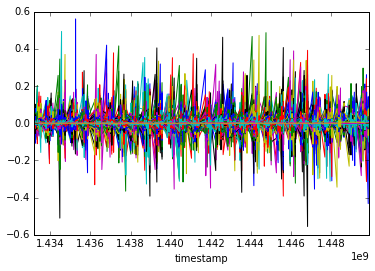

In [5]:
dif_df.plot(legend=False)

In [6]:
# X[0] is now NAs because we diffed
X = dif_df.values[1:]
X

array([[ 0.        , -0.00377181, -0.01050876, ..., -0.00201342,
         0.        ,  0.        ],
       [ 0.        , -0.00118315, -0.01073837, ..., -0.00571621,
         0.        ,  0.        ],
       [ 0.        , -0.00047382, -0.00652659, ..., -0.00473453,
         0.        ,  0.        ],
       ..., 
       [ 0.0064538 , -0.00652681, -0.0117855 , ..., -0.00471628,
         0.        ,  0.        ],
       [ 0.00371245,  0.00164242,  0.00238521, ...,  0.00101833,
        -0.00099502,  0.        ],
       [ 0.00302623, -0.00562193, -0.00416419, ...,  0.00847745,
         0.        ,  0.        ]])

In [6]:
dif_df.columns

Index([u'aaap', u'aal', u'aaoi', u'aaon', u'aapc', u'aapl', u'aavl', u'aaww',
       u'abax', u'abcb',
       ...
       u'zion', u'ziop', u'zltq', u'zsan', u'zsph', u'zumz', u'zvv', u'zvzzt',
       u'zxyz-a', u'zyne'],
      dtype='object', length=2280)

In [8]:
n_components=25
factorization = SparsePCA(n_components=n_components, alpha=0.03, max_iter=10)
factorization.fit(X)

SparsePCA(U_init=None, V_init=None, alpha=0.03, max_iter=10, method='lars',
     n_components=25, n_jobs=1, random_state=None, ridge_alpha=0.01,
     tol=1e-08, verbose=False)

In [11]:
def analyze_component(component, component_labels, company_df, vocab,
                                n_companies=20, n_words=20):
    '''
    component: 1d numpy array representing a linear combination of companies
    component_labels: the ticker symbols of the companies from component
    company_df: pandas dataframe with index ticker symbols, a column 'description' with a
                text description of the company and a column 'tfidf' a tfidf vector
    vocab: the vocab for the tfidf vector above
    
    returns: A dictionary with the following information about the company:
                'companies_pro': Numpy array of ticker symbols of the top n_companies
                                 companies associated with this component
                'importances_pro': Numpy array of floats that tell the weight of the
                                   above companies in the principle component
                'companies_con': Numpy array of ticker symbols of the top n_companies
                                 companies anti-correlated with this component
                'importances_con': Numpy array of floats that tell the weight of the
                                   above companies in the principle component 
                                   (these numbers are positive, measuring the anti-correlation)
                'words_pro':
                'word_importances_pro':
    '''
    d = {}
    idx_con = np.argsort(component)[:n_companies]
    d['companies_con'] = component_labels[idx_con]
    d['importances_con'] = component[idx_con] * -1.
    
    idx_pro = np.argsort(component)[::-1][:n_companies]
    d['companies_pro'] = component_labels[idx_pro]
    d['importances_pro'] = component[idx_pro]
    
    # TODO: Weight the word importances by the company importance
    word_importances_list_con = company_df.ix[d['companies_con'], :]['tfidf']
    weighted_word_impt_list_con = word_importances_list_con.multiply(d['importances_con'], fill_value=0)
    
    word_importances_con = weighted_word_impt_list_con.mean()
    #word_importances_con = company_df.ix[d['companies_con'], :]['tfidf'].mean()
    word_idx_con = word_importances_con.argsort()[::-1][:n_words]
    d['words_con'] = np.array(vocab)[word_idx_con]
    d['word_importances_con'] = word_importances_con[word_idx_con]
    
    word_importances_list_pro = company_df.ix[d['companies_pro'], :]['tfidf']
    weighted_word_impt_list_pro = word_importances_list_pro.multiply(d['importances_pro'], fill_value=0)
    
    word_importances_pro = weighted_word_impt_list_pro.mean()
    #word_importances_pro = company_df.ix[d['companies_pro'], :]['tfidf'].mean()
    word_idx_pro = word_importances_pro.argsort()[::-1][:n_words]
    d['words_pro'] = np.array(vocab)[word_idx_pro]
    d['word_importances_pro'] = word_importances_pro[word_idx_pro]
    
    return d
    
d = analyze_component(factorization.components_[0], dif_df.columns.values,
                                 company_df, vocab)

In [12]:
def draw_importances_graph(names, importances, title, ax):
    n = len(names)
    #ax.figure()
    ax.set_title(title, fontdict={'fontsize': 10})
    ax.bar(range(n), importances,
           color="r", align="center")
    ax.set_xticks(range(n))
    ax.set_xticklabels(names, rotation='vertical')
    ax.set_xlim([-1, n])
    labels = ax.get_xticks()
    ax.tick_params(labelsize=20)

In [13]:
def graph_component(d):
    f, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(18, 18))
    f.subplots_adjust(bottom=0.01)

    draw_importances_graph(d['companies_con'],
                           d['importances_con'], 
                           "Company Importances Con",
                           ax1)

    draw_importances_graph(d['words_con'],
                           d['word_importances_con'], 
                           "Word Importances Con",
                           ax2)

    draw_importances_graph(d['companies_pro'],
                           d['importances_pro'], 
                           "Company Importances Pro",
                           ax3)

    draw_importances_graph(d['words_pro'],
                           d['word_importances_pro'], 
                           "Word Importances Pro",
                           ax4)


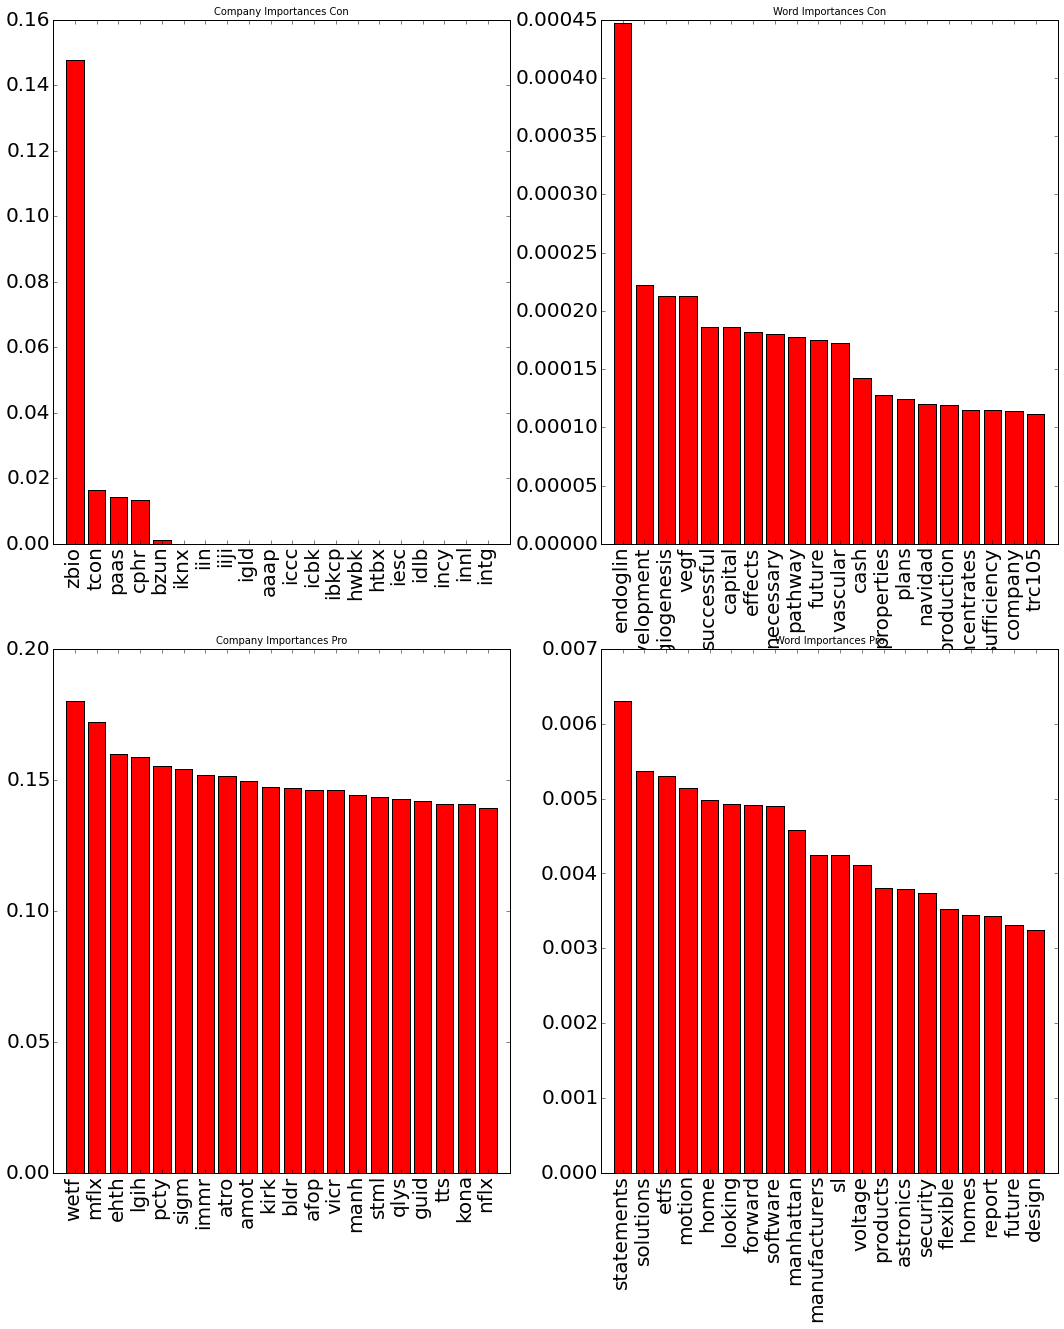

In [17]:
d = analyze_component(factorization.components_[0], dif_df.columns.values,
                                 company_df, vocab)
graph_component(d)


In [17]:
# We can clean up the data and get better results by finding a way to dedupe the list of
# companies.  Some are subsidiaries of the others and track very closely.  These are then 
# overrepresented in the data.

In [18]:
# Biotech and pharma seems to be overrepresented in the data.  What is going on with 
# that.  

In [19]:
# We could try daily instead of hourly.  

In [ ]:
# TODO: Weight the tfidf average by company importance.  

In [ ]:
# In ModelBuilder.py:
## Build the model
### Decide what stocks to use
### Subset the dataframe
### Construct model
## Pickle the model
# In Summarizer.py:
## Unpickle the model.
## Provide a way to get an hours market change from the dataset
## Given a dataframe of deltas for all the stocks
### Project onto principle componenets of model
### Calculate the error vector